In [1]:
import numpy as np
import pandas as pd
import GPy
import time
import sys
import os
import pdb
import matplotlib.pyplot as plt

from context import aep
from context import load_data
from context import delete_blocks
from context import start_df
from context import save_df
from context import metrics
from thesis_work.plots import GP_figures
from thesis_work.plots import SGP_figures
from thesis_work.plots import DGP_figures

from baseline_models import full_GP_reg
from baseline_models import sparse_GP_reg
from aep_config import cont_optimization
from aep_config import aep_DGP_reg

default_dict = {'M': 40, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':100,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
os.getcwd()
%matplotlib notebook

Dataset size:  2500  Test size:  1000.0
Training:  750


<IPython.core.display.Javascript object>


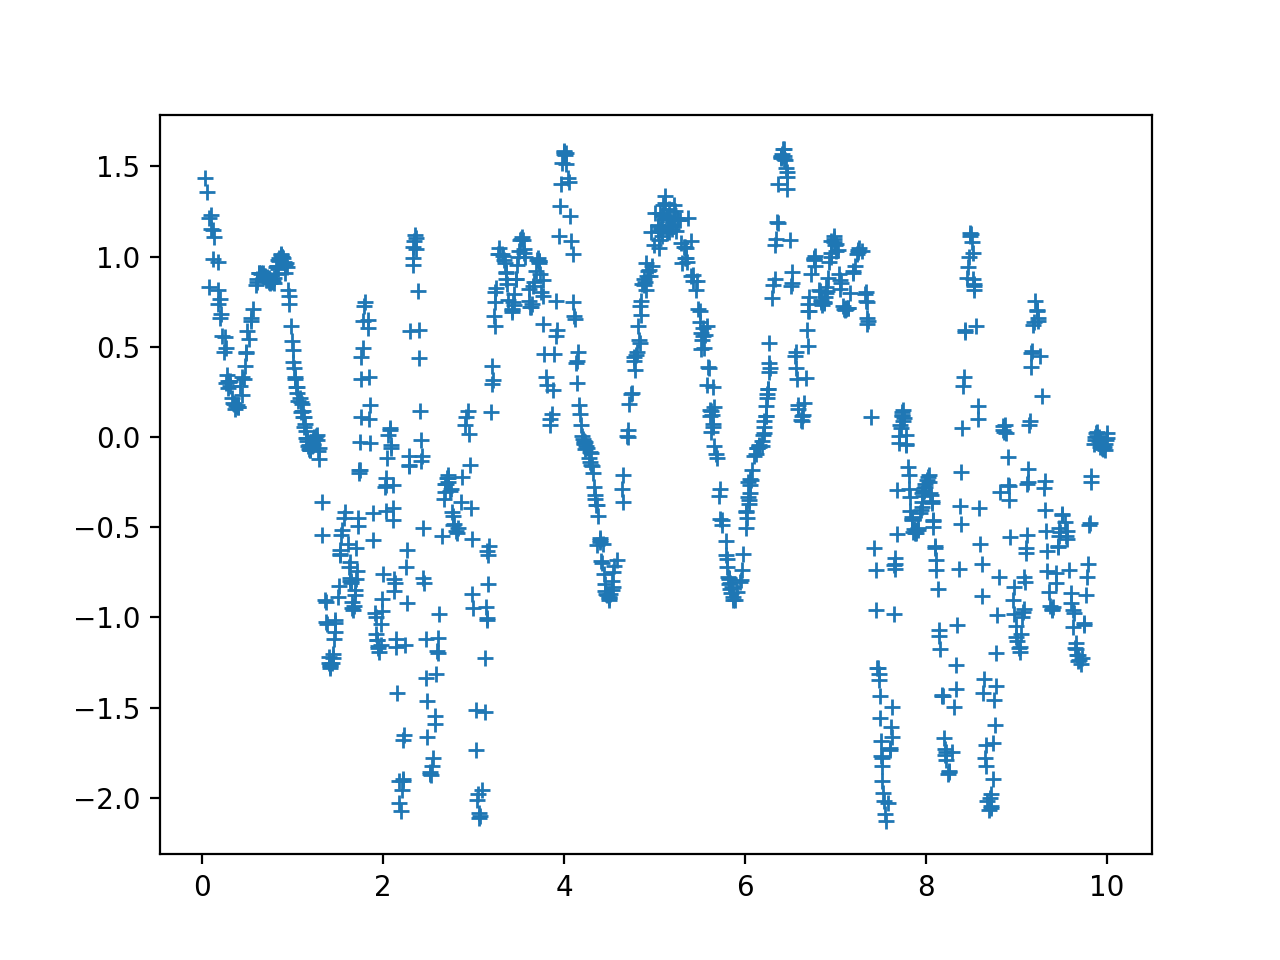

In [2]:
path = 'data/sample_3.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=750, test=0.4, norm_out=False)
# X_test, y_test = delete_blocks(X_test, y_test,
#                                intervals=[3.5,6])
plt.figure()
plt.plot(X_test, y_test, '+')
plt.show()

Create DGP model and optimize ...
Optimise with fixed:  ['zu_0', 'sf_0', 'ls_0', 'eta2_0']
SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0
iter 0 	 obj 3.401
iter 50 	 obj 1.263
iter 100 	 obj 0.551
iter 150 	 obj 0.086
iter 200 	 obj -0.090
iter 250 	 obj -0.207
iter 300 	 obj -0.246
iter 350 	 obj -0.241
iter 400 	 obj -0.222
iter 450 	 obj -0.278
iter 500 	 obj -0.316
iter 550 	 obj -0.309
iter 600 	 obj -0.337
iter 650 	 obj -0.325
iter 700 	 obj -0.330
iter 750 	 obj -0.347
Test MSE= 0.007, NLL= -0.934, SN= 0.086


<IPython.core.display.Javascript object>


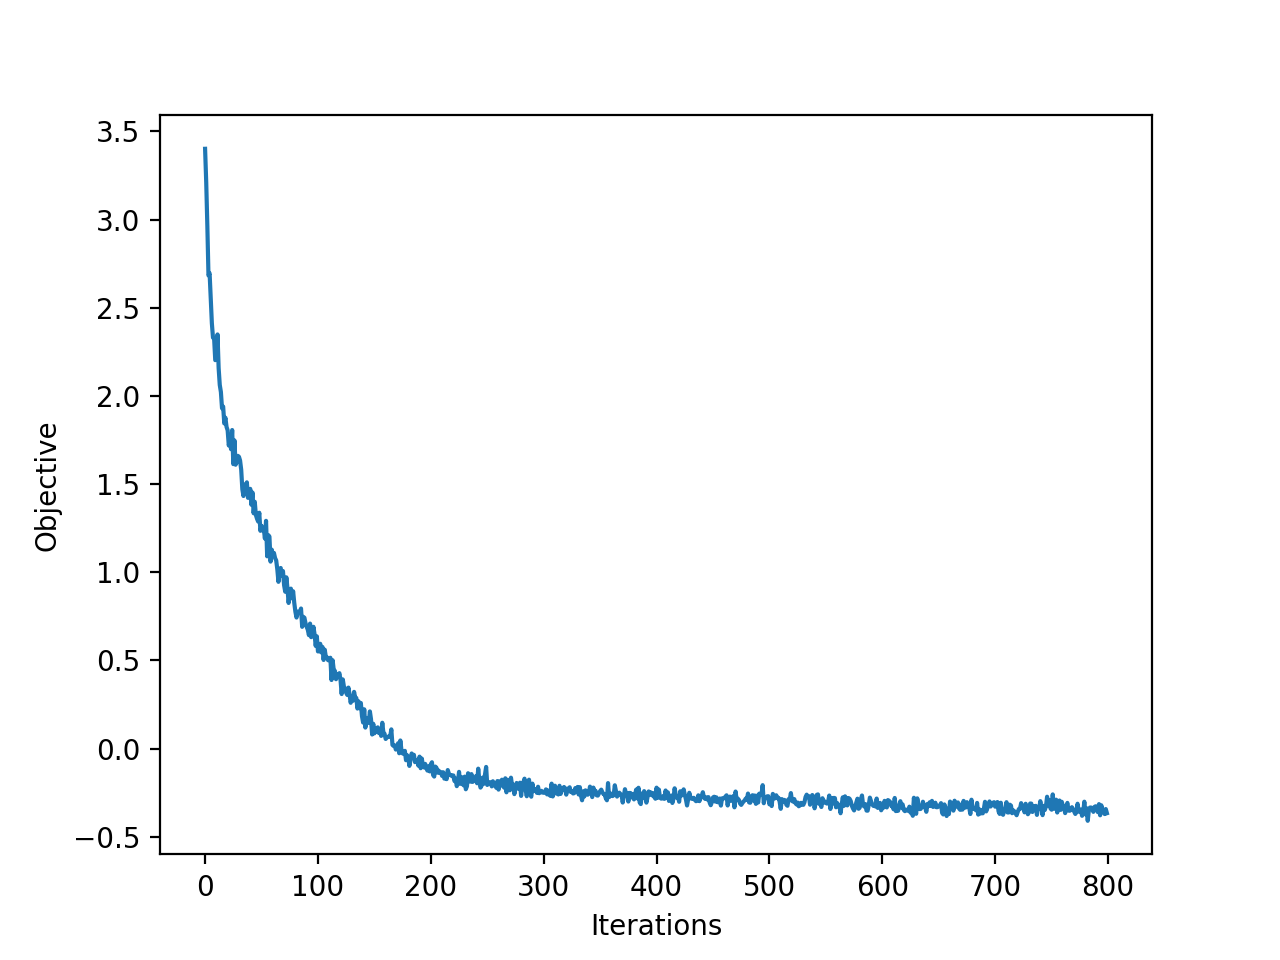

In [7]:
N_train = X_train.shape[0]
# ['zu_0', 'sf_0', 'ls_0', 'eta2_0', 'eta1_R_0']
config_dict = {'M': 75, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':800,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': ['zu_0', 'sf_0', 'ls_0', 'eta2_0'],
            'init_type':'greedy'}

model, df, costs = aep_DGP_reg(X_train, y_train, X_test, y_test, 
				conf_dict= config_dict,
				return_cost=True)
fig0 = DGP_figures(model,conf_dict=config_dict).plot_cost(costs)

In [8]:
config_dict2 = {'M':75, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1000,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':'greedy'}
model, df = cont_optimization(model, X_test, y_test, conf_dict=config_dict2,
                              new_max_it=1000, return_cost=False)

Optimise with fixed:  []
iter 0 	 obj -0.349
iter 50 	 obj -0.419
iter 100 	 obj -0.357
iter 150 	 obj -0.439
iter 200 	 obj -0.438
iter 250 	 obj -0.468
iter 300 	 obj -0.375
iter 350 	 obj -0.529
iter 400 	 obj -0.439
iter 450 	 obj -0.493
iter 500 	 obj -0.491
iter 550 	 obj -0.463
iter 600 	 obj -0.486
iter 650 	 obj -0.477
iter 700 	 obj -0.492
iter 750 	 obj -0.505
iter 800 	 obj -0.490
iter 850 	 obj -0.473
iter 900 	 obj -0.478
iter 950 	 obj -0.493
Test MSE= 0.007, NLL= -1.098, SN= 0.071


Default initialisation


<IPython.core.display.Javascript object>


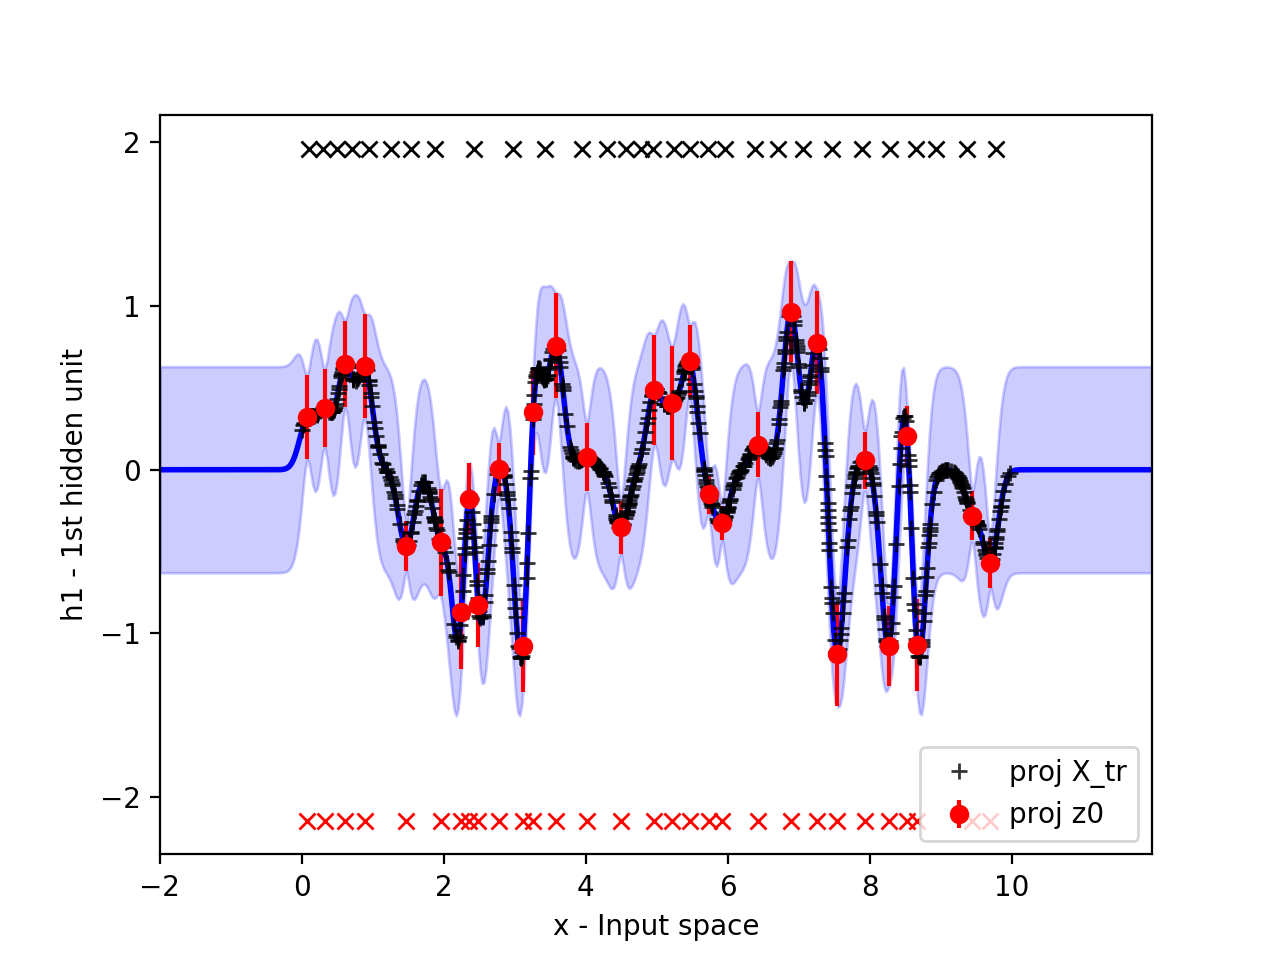

<IPython.core.display.Javascript object>


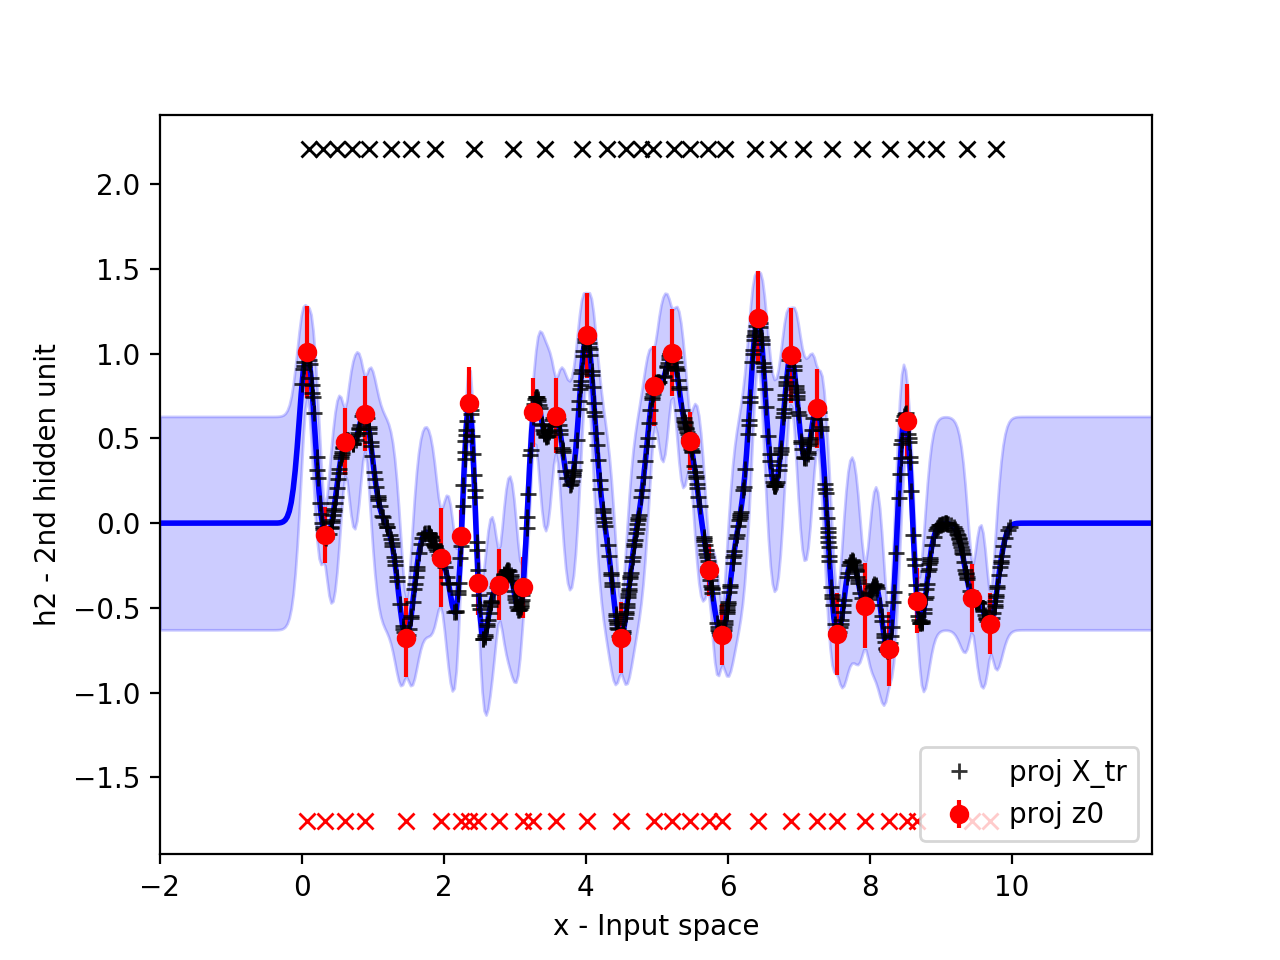

Default initialisation


<IPython.core.display.Javascript object>


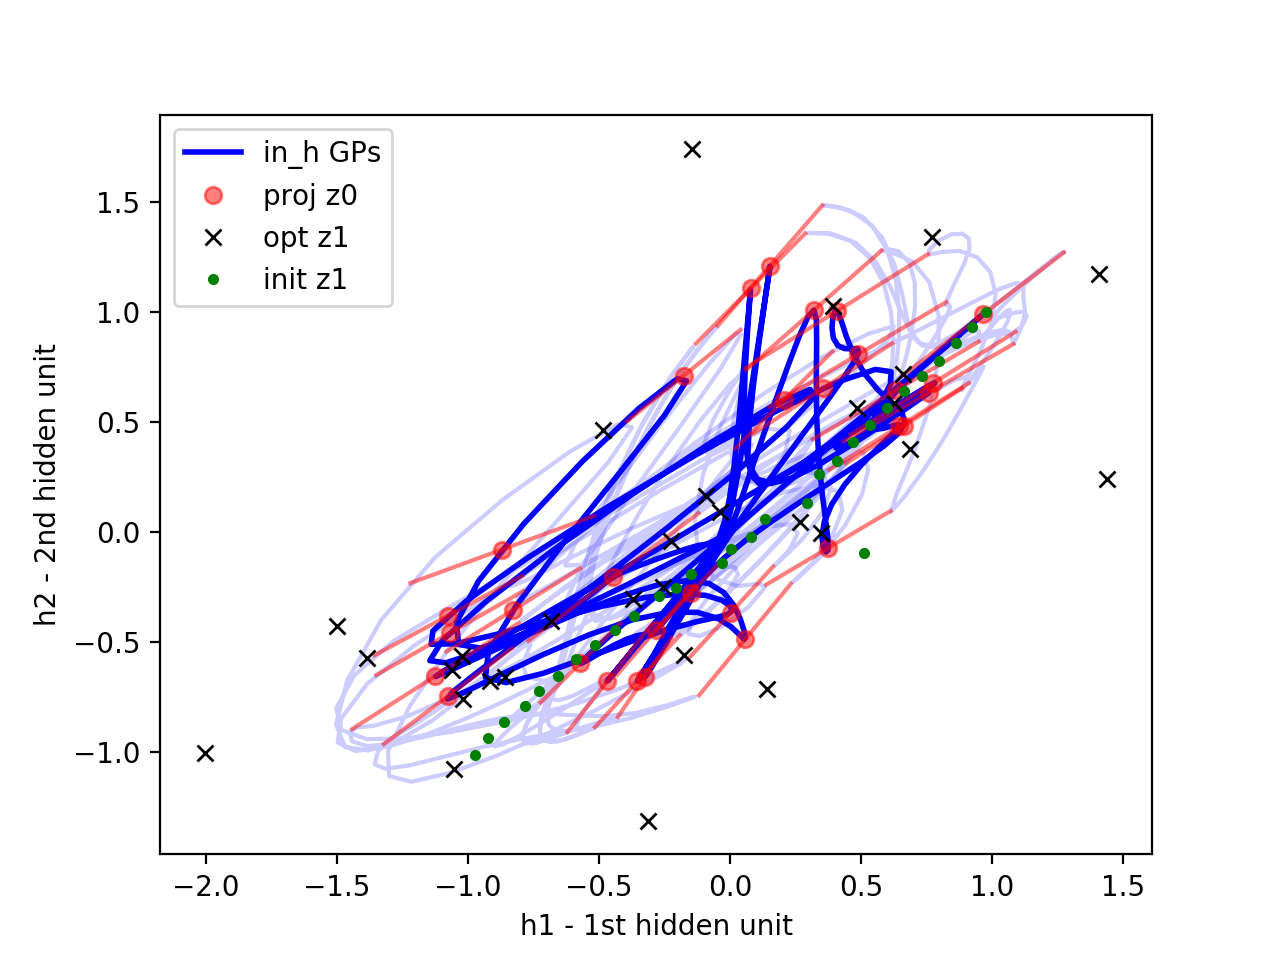

<IPython.core.display.Javascript object>


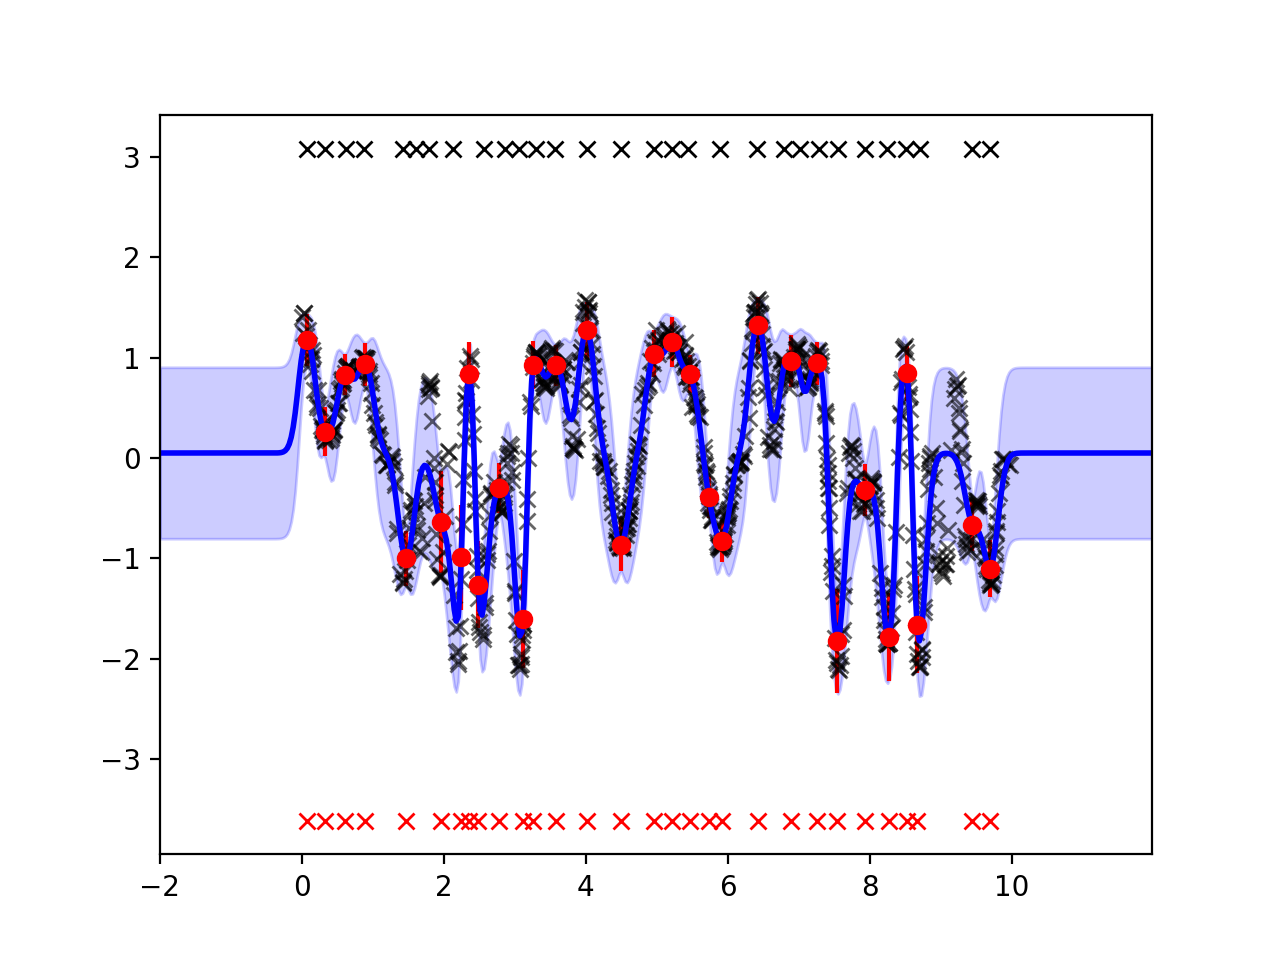

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


In [7]:
fig3 = DGP_figures(model, conf_dict=config_dict).plot_in_h()
fig4 = DGP_figures(model, conf_dict=config_dict).plot_hidden()
fig5 = DGP_figures(model, conf_dict=config_dict).plot()

create SGP model and optimize ...
Test MSE =0.007, NLL =-0.840


<IPython.core.display.Javascript object>


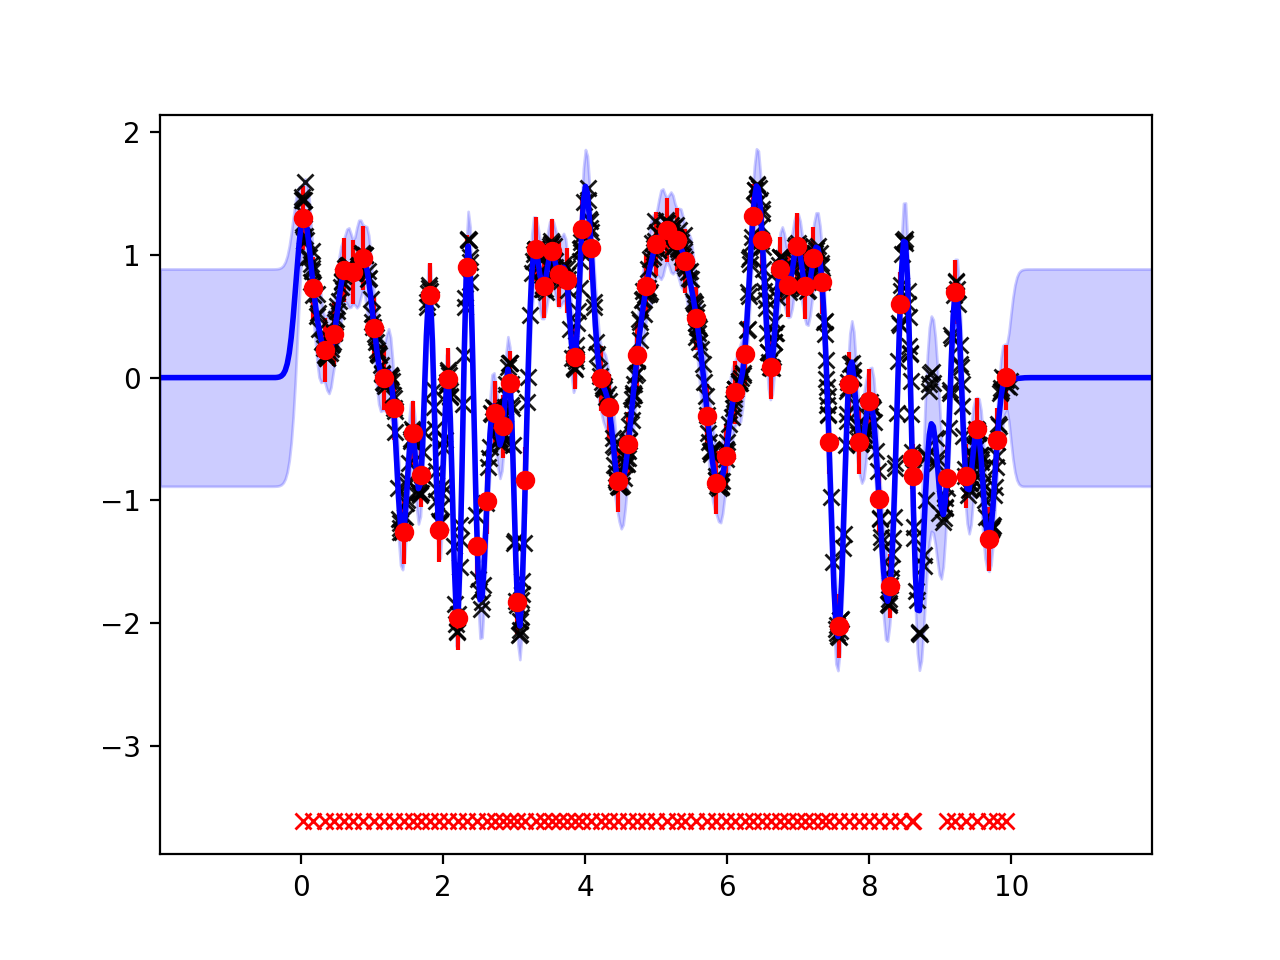

In [9]:
model_sgp, df = sparse_GP_reg(X_train, y_train, X_test, y_test, M=75)
fig = SGP_figures(model_sgp).plot()

0.014619702432 -0.319754326062


<IPython.core.display.Javascript object>


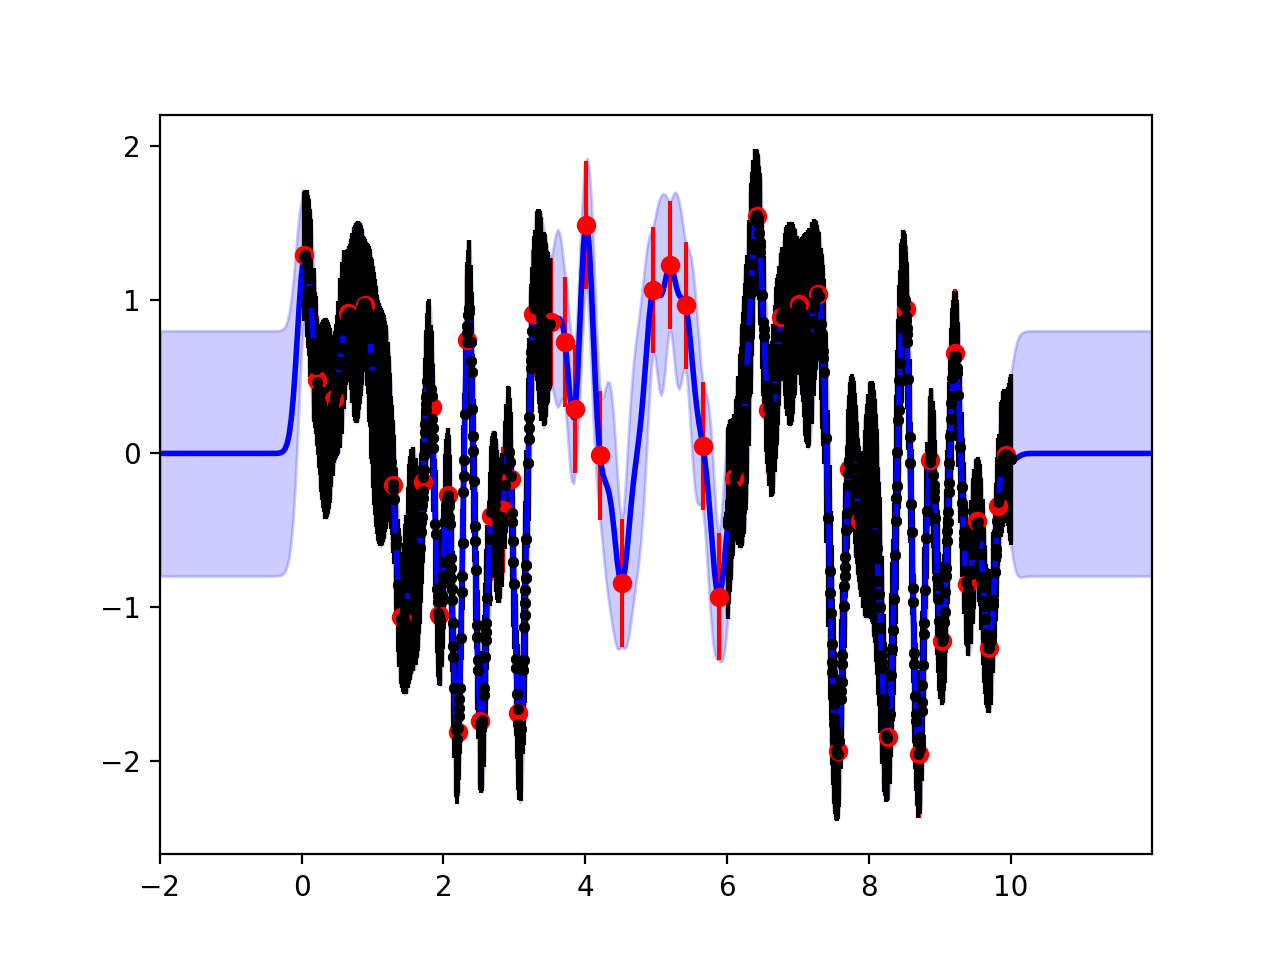

(-1.9959983993597439, 11.987995198079233)

In [25]:
mean_sgp, var_sgp = model_sgp.predict(X_test)
results_sgp = metrics.METRICS(y_test, mean_sgp, var_sgp)
mse_sgp , nll_sgp = results_sgp.mse(), results_sgp.nll() 
print mse_sgp , nll_sgp 
x_min, x_max = np.min(model_sgp.X)-2, np.max(model_sgp.X)+2
xx = np.linspace(x_min, x_max, 500)[:, None]
mean, var = model_sgp.predict(xx)
fig = plt.figure()
# plt.plot(model_sgp.X, model_sgp.Y, 'kx', mew=1, alpha=0.9)
plt.plot(xx, mean, 'b', lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 2 * np.sqrt(var[:, 0]),
    mean[:, 0] + 2 * np.sqrt(var[:, 0]),
    color='blue', alpha=0.2)
zu = model_sgp.Z.values
mean_u, var_u = model_sgp.predict(zu)
plt.errorbar(zu, mean_u, yerr=2 * np.sqrt(var_u), fmt='ro')
y_min = np.min(mean) - 1.5
# plt.plot(zu, y_min * np.ones(zu.shape), 'rx')
plt.plot(X_test, mean_sgp, '.k')
plt.errorbar(X_test, mean_sgp, yerr=2 * np.sqrt(var_sgp), fmt='k.')
plt.xlim(x_min, x_max)

In [4]:
print metrics.ho_nll_samples(model, X_test, y_test, N_samples=100)
print metrics.nll_MLE_samples(model, X_test, y_test, N_samples=100)

0.939740480747
0.694700429384


In [6]:
print metrics.METRICS(y_test, model.predict_y(X_test)[0],model.predict_y(X_test)[1]).nll()
print metrics.ho_nll_samples(model, X_test, y_test, N_samples=100)
print metrics.nll_MLE_samples(model, X_test, y_test, N_samples=100)

0.115958130262
0.446704131523
0.440488326924


In [5]:
def nll_MLE_samples(model, X_test, y_test, N_samples=100):
	N_test = X_test.shape[0]
	samples = model.sample_f(X_test, no_samples=N_samples).reshape(-1,N_samples)
	m = np.mean(samples,axis=1).reshape(-1,1)
	v = np.var(samples,axis=1).reshape(-1,1)
	sn = np.exp(model.get_hypers()['sn'])
	nll_samples = METRICS(y_test, m, v + sn * np.eye(N_test)).nll()
	return nll_samples

nll_MLE_samples(model, X_test, y_test, N_samples=100)

NameError: global name 'METRICS' is not defined